# Diffusion model for clutter denoising

## Initialization

### Imports

In [14]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch import einsum
from models.unet import *
import torch.optim as optim
from utils.trainer import *
#from models.newdif import *
from torch.optim import Adam
from utils.plotters import *
from utils.inference import *
from models.diffusion import *
from dataset.radardata import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
from types import SimpleNamespace
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

### Define device

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialiaze W&B + config

In [16]:
run_name = 'HTGDiffusion'

In [17]:
wandb.init(
    project="New-Radar-diffusion2",
    name=run_name,
    notes="Regular diffusion. this experiment is our benchmark - we check if changes are performing better or worse",
    config={
        "beta_end": 0.02,
        "beta_start": 1e-4,
        "batch_size": 16,
        "num_epochs": 400,
        "noise_steps": 2000,
        "num_workers": 4,
        "time_emb_dim": 256,
        "learning_rate": 1e-4,        
        "scheduler_type": "linear",
    },
)
config = wandb.config

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


## dataset prep

In [18]:
norm_train_dataset = torch.load("norm_train_dataset_1015.pt", weights_only=False)
norm_val_dataset   = torch.load("norm_val_dataset_1015.pt",   weights_only=False)
norm_train_loader = DataLoader(
    norm_train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers
)

norm_val_loader = DataLoader(
    norm_val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers
)

## train

In [21]:
train_loader = norm_train_loader
val_loader = norm_val_loader
cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=config.time_emb_dim).to(device)
# cond_diffusion = HTGDiffusion(
#     model           = cond_unet,
#     T               = 1000,
#     noise_type      = "studentt",  # or "gamma"
#     nu              = 4.0,         # heavier tails ↘ smaller ν (ν>2 for finite var)
#     loss_type       = "gamma_div", # or "mse"
#     gamma_param     = 0.3          # γ∈(0,2); γ≈0.3 works well for heavy tails
# ).to(device)
# cond_diffusion = StudentTDiffusion(
#     model=cond_unet,
#     nu=4.0,        # tail‐heaviness
#     gamma=0.7,     # divergence strength
#     scheduler_type="cosine",
#     T=2000,
#     beta_start=1e-4,
#     beta_end=0.02
# ).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, scheduler_type=config.scheduler_type, T=config.noise_steps, 
    beta_start=config.beta_start, beta_end=config.beta_end).to(device)

#(model=cond_unet, scheduler_type=config.scheduler_type, T=config.noise_steps, 
#    beta_start=config.beta_start, beta_end=config.beta_end).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), config.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4, cooldown=15, min_lr=1e-6, verbose=True)
num_epochs = config.num_epochs

/home/hawk/Desktop/Heavy-Clutter-Detection/finalDiffusion/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
best_val_loss = float('inf')
best_mse_loss = float('inf')
train_losses, val_losses, val_psnrs, val_mses = [], [], [], []
e_mse_loss = None
e_rd_loss = None
iq_val_loss = None
rd_val_loss = None

for epoch in range(num_epochs):
    #train_loss, e_mse_loss, e_rd_loss= train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    #val_loss, iq_val_loss, rd_val_loss, gen_mse, gen_psnr, rd_mse = validate(cond_diffusion, val_loader, device)

    train_loss= train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")

    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")

    scheduler.step(val_loss)

    if gen_mse < best_mse_loss:
        best_mse_loss = gen_mse
        torch.save(cond_diffusion.state_dict(), f"{run_name}.pth")
        print("   --> Best MSE model saved.")

    wandb.log({
        "total train loss": train_loss,
        "total val loss": val_loss,
        "MSE between denoised IQ and clean IQ": gen_mse if gen_mse is not None else float('nan'),
        "generated IQ map PSNR": gen_psnr,
        "learning rate": optimizer.param_groups[0]['lr']  # Optional, log current LR
    })


Epoch 1/400: Train Loss = 0.4655 | Val Loss = 0.4111
   [Generation Metrics] MSE: 1.1079 | PSNR: 34.22 dB
   --> Best MSE model saved.
Epoch 2/400: Train Loss = 0.4014 | Val Loss = 0.3987
   [Generation Metrics] MSE: 1.1048 | PSNR: 34.23 dB
   --> Best MSE model saved.
Epoch 3/400: Train Loss = 0.3883 | Val Loss = 0.3839
   [Generation Metrics] MSE: 1.1732 | PSNR: 33.97 dB
Epoch 4/400: Train Loss = 0.3807 | Val Loss = 0.3773
   [Generation Metrics] MSE: 1.2072 | PSNR: 33.84 dB
Epoch 5/400: Train Loss = 0.3757 | Val Loss = 0.3703
   [Generation Metrics] MSE: 1.2897 | PSNR: 33.56 dB
Epoch 6/400: Train Loss = 0.3732 | Val Loss = 0.3661
   [Generation Metrics] MSE: 1.3036 | PSNR: 33.51 dB
Epoch 7/400: Train Loss = 0.3694 | Val Loss = 0.3659
   [Generation Metrics] MSE: 1.4178 | PSNR: 33.14 dB
Epoch 8/400: Train Loss = 0.3662 | Val Loss = 0.3688
   [Generation Metrics] MSE: 1.3218 | PSNR: 33.45 dB
Epoch 9/400: Train Loss = 0.3634 | Val Loss = 0.3627
   [Generation Metrics] MSE: 1.5020 | PSN

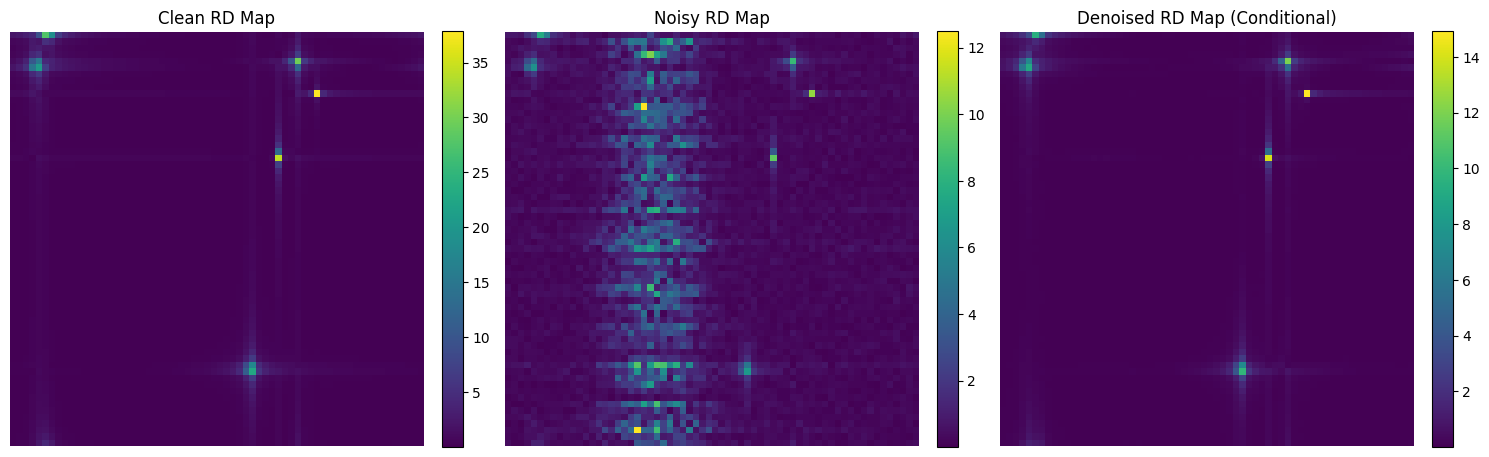

In [26]:
checkpoint_path = "/home/hawk/Desktop/Heavy-Clutter-Detection/finalDiffusion/range_doppler_trial.pth"
run_inference(cond_diffusion , norm_val_dataset, checkpoint_path, device)